In [384]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import scipy as scipy
from scipy.optimize import minimize
import sys

BACKTEST = 5 #years
LOWER_BOUND = 0 #increase for diversification 
UPPER_BOUND = 0.4
NUM_OF_SIMULATIONS = 5000 #for monte carlo simulation
lambda_penalty = 0 #increase for robustness & diversificaiton, try 0.1 ~ 10

In [385]:
endDate = dt.datetime.today() + dt.timedelta(hours = 9) #한국 시간 기준
startDate = endDate - dt.timedelta(days = 365 * BACKTEST)

#tickers = ['SPY', 'SCHD', 'QQQ', 'BTC-USD']
tickers = ['BTC-USD', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']

In [386]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df.head())

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                BTC-USD       AAPL        MSFT      NVDA       GOOG  \
Date                                                                  
2020-05-09  9593.896484        NaN         NaN       NaN        NaN   
2020-05-10  8756.430664        NaN         NaN       NaN        NaN   
2020-05-11  8601.795898  76.653244  178.743576  8.035893  69.832237   
2020-05-12  8804.477539  75.777245  174.694717  7.773859  68.462730   
2020-05-13  9269.987305  74.862312  172.052887  7.751441  67.148460   

                  AMZN        META       BRK-B       AVGO        TSM  \
Date                                                                   
2020-05-09         NaN         NaN         NaN        NaN        NaN   
2020-05-10         NaN         NaN         NaN        NaN        NaN   
2020-05-11  120.449997  212.179977  174.639999  24.240078  47.833664   
2020-05-12  117.847504  209.114426  172.809998  23.628351  46.646946   
2020-05-13  118.396004  204.137909  170.570007  23.161850  46.482635  

In [387]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [388]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          BTC-USD      AAPL      MSFT      NVDA      GOOG      AMZN      META  \
BTC-USD  0.281938  0.045413  0.049353  0.081330  0.049868  0.056108  0.055240   
AAPL     0.045413  0.089481  0.056219  0.090845  0.055785  0.066889  0.074759   
MSFT     0.049353  0.056219  0.077508  0.096669  0.060914  0.071273  0.076178   
NVDA     0.081330  0.090845  0.096669  0.276172  0.093413  0.115687  0.129028   
GOOG     0.049868  0.055785  0.060914  0.093413  0.101032  0.076460  0.089148   
AMZN     0.056108  0.066889  0.071273  0.115687  0.076460  0.135901  0.106863   
META     0.055240  0.074759  0.076178  0.129028  0.089148  0.106863  0.219829   
BRK-B    0.024428  0.024914  0.020739  0.031130  0.023787  0.025004  0.028071   
AVGO     0.057529  0.065733  0.062980  0.143151  0.061385  0.077955  0.085350   
TSM      0.049975  0.054268  0.052150  0.132149  0.055088  0.065675  0.076385   
WMT      0.016365  0.020154  0.016282  0.022491  0.016390  0.022577  0.018994   
LLY      0.014337  0.023807 

In [389]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [390]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [391]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [ ]:
from fredapi import Fred
#https://fredaccount.stlouisfed.org/apikey
fred = Fred(api_key = '')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
# print(risk_free_rate)

/tmp/ipykernel_4419/3437368303.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = ten_year_treasury_rate[-1]


In [393]:
#핵심
#OPTIMIZE the portfolio using different techniques here like
# monte carlo simulation, mathematical optimization, etc
# other alternatives include black-litterman model, min variance, 
# max diversification/risk pairty, 

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) + (lambda_penalty * np.sum(weights**2))

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#say you wanna fix AVGO's weight to be exactly 0.25. if you want it to be at least 0.25, change 'eq' to 'ineq'
#constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
#               {'type': 'eq', 'fun': lambda weights: weights[tickers.index('AVGO')] - 0.25}]
bounds = [(LOWER_BOUND, UPPER_BOUND) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [394]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [395]:
optimal_weights = optimized_results.x #.x gets the results

In [405]:
# print("Optimal Weights:")
# for ticker, weight in zip(tickers, optimal_weights):
#     print(f"{ticker}: {weight:.4f}")

# optimal_portfolio_return = expected_return(optimal_weights, log_returns)
# optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
# optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

# print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
# print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
# print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

In [404]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.bar(tickers, optimal_weights)

# plt.xlabel('Assets')
# plt.ylabel('Optimal Weights')
# plt.title('Optimal Portfolio Weights')

# plt.show()

In [398]:
# Initialize the components, to run a Monte Carlo Simulation.
number_of_symbols = len(tickers)
# We will run 5000 iterations.
num_of_portfolios = NUM_OF_SIMULATIONS

float_formatter = "{:.2f}".format

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_returns.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio

simulations_data = [ret_arr, vol_arr, sharpe_arr, np.round(all_weights, 4)]
# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

data = {
    'Portfolio Weights': [
        np.random.rand(10).tolist() for _ in range(5000)
    ]
}
df = pd.DataFrame(data)

# Set Pandas to display all columns and rows
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_colwidth', None)  # To prevent truncation of column values

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
MAX_LINE = 200
# print('')
# print('='*MAX_LINE)
# print('SIMULATIONS RESULT:')
# print('-'*MAX_LINE)
# with np.printoptions(threshold=sys.maxsize):
#     print(simulations_df)
# print('-'*MAX_LINE)

In [399]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
monte_carlo_max_sharpe_weights = max_sharpe_ratio.loc['Portfolio Weights']
# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]
monte_carlo_min_vol_weights = min_volatility.loc['Portfolio Weights']

print('')
print('='*MAX_LINE)
print('MAX SHARPE RATIO:')
print('-'*MAX_LINE)
print(max_sharpe_ratio)
print('-'*MAX_LINE)

print('')
print('='*MAX_LINE)
print('MIN VOLATILITY:')
print('-'*MAX_LINE)
print(min_volatility)
print('-'*MAX_LINE)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Returns                                                                                                              0.290243
Volatility                                                                                                           0.201672
Sharpe Ratio                                                                                                         1.439185
Portfolio Weights    [0.1031, 0.0874, 0.0385, 0.0155, 0.0035, 0.0001, 0.0319, 0.1713, 0.1316, 0.0494, 0.0781, 0.1902, 0.0994]
Name: 2704, dtype: object
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------

Re-reun SLSQP Optimization with weights from Monte Carlo simulation as initial guess to land a global Sharpe Maximum and enhance results

In [400]:
optimized_results_max_sharpe = minimize(neg_sharpe_ratio, monte_carlo_max_sharpe_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results_min_vol = minimize(neg_sharpe_ratio, monte_carlo_min_vol_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [401]:
optimal_weights = optimized_results_max_sharpe.x
# optimal_weights = optimized_results_min_vol.x

print("Optimal Weights - Monte Carlo Adjusted:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights - Monte Carlo Adjusted:
BTC-USD: 0.0468
AAPL: 0.0000
MSFT: 0.0000
NVDA: 0.0954
GOOG: 0.0000
AMZN: 0.0000
META: 0.0000
BRK-B: 0.4000
AVGO: 0.1695
TSM: 0.0000
WMT: 0.0000
LLY: 0.2883
JPM: 0.0000
Expected Annual Return: 0.3410
Expected Volatility: 0.2091
Sharpe Ratio: 1.4262


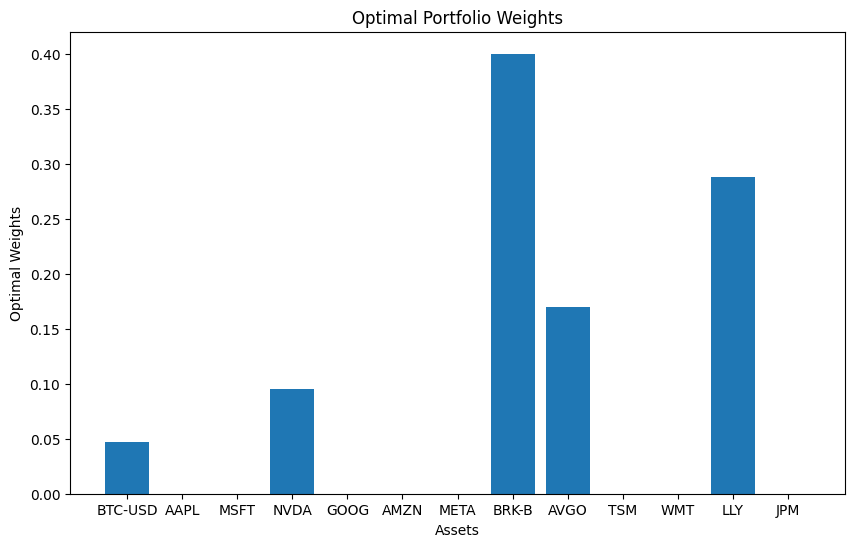

In [402]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()